# Parker Solar Probe Examples

In [9]:
from utils.io import load_psp_data, time_stamp
from pytplot import tplot, tlimit, timebar
import pytplot
from utils.config import PSPConfig

In [2]:
tnames = load_psp_data()

0 : psp_fld_l2_mag_RTN_4_Sa_per_Cyc
1 : psp_swp_spi_sf00_L3_DENS
2 : psp_swp_spi_sf00_L3_VEL_RTN_SUN
3 : psp_swp_spi_sf00_L3_VEL_RTN
4 : psp_swp_spi_af00_L3_DENS
5 : psp_swp_spi_af00_L3_VEL_RTN_SUN
6 : psp_swp_spi_af00_L3_VEL_RTN
7 : Tp_spani_b
8 : Tp_spanib_b


In [24]:
import polars as pl
  
def find_events(df: pl.DataFrame):
    return df.with_columns(
        Λ_t = 1 - (pl.col("v.ion.change.l") / pl.col("v.Alfven.change.l")) ** 2
    ).with_columns(
        rate =  (pl.col("Λ_ion") / pl.col("Λ_t") - 1).abs()
    ).sort("rate")
    
p_conf = PSPConfig(enc=7).load()
events = find_events(p_conf.events).head()

In [4]:
def plot_event(event, tnames2plot, td_stop_c = "t.d_end", add_timebars = True):
    tstart = time_stamp(event["tstart"])
    tstop = time_stamp(event["tstop"])
    td_start = event["t.d_start"]
    td_stop = event[td_stop_c]
    
    tlimit([tstart,tstop])

    if add_timebars:
        timebar(time_stamp(td_start))
        timebar(time_stamp(td_stop))

    tplot(tnames2plot)

In [5]:
from discontinuitypy.utils.plot import plot_candidate
from pytplot import get_data

def plot_candidate_tplot(event, name= 'psp_fld_l2_mag_RTN_4_Sa_per_Cyc'):
    da = get_data(name, xarray=True)
    return plot_candidate(event, da)

In [16]:
tnames2plot = [
    'psp_fld_l2_mag_RTN_4_Sa_per_Cyc',
    'psp_swp_spi_sf00_L3_DENS',
    'psp_swp_spi_sf00_L3_VEL_RTN_SUN',
    'Tp_spani_b'
]

In [32]:
from great_tables import GT

GT(events.select("tstart", "tstop", "Λ_t", "Λ_ion")).fmt_datetime(
    columns=["tstart", "tstop"]
).fmt_number(columns=["Λ_t", "Λ_ion"], decimals=2)

tstart,tstop,Λ_t,Λ_ion
2021-01-17 13:22:56,2021-01-17 13:23:12,0.90,0.74
2021-01-17 14:00:40,2021-01-17 14:00:56,0.46,0.57
2021-01-17 14:04:08,2021-01-17 14:04:24,1.00,0.73
2021-01-17 14:02:48,2021-01-17 14:03:04,0.70,0.92
2021-01-17 13:54:16,2021-01-17 13:54:32,0.79,0.51


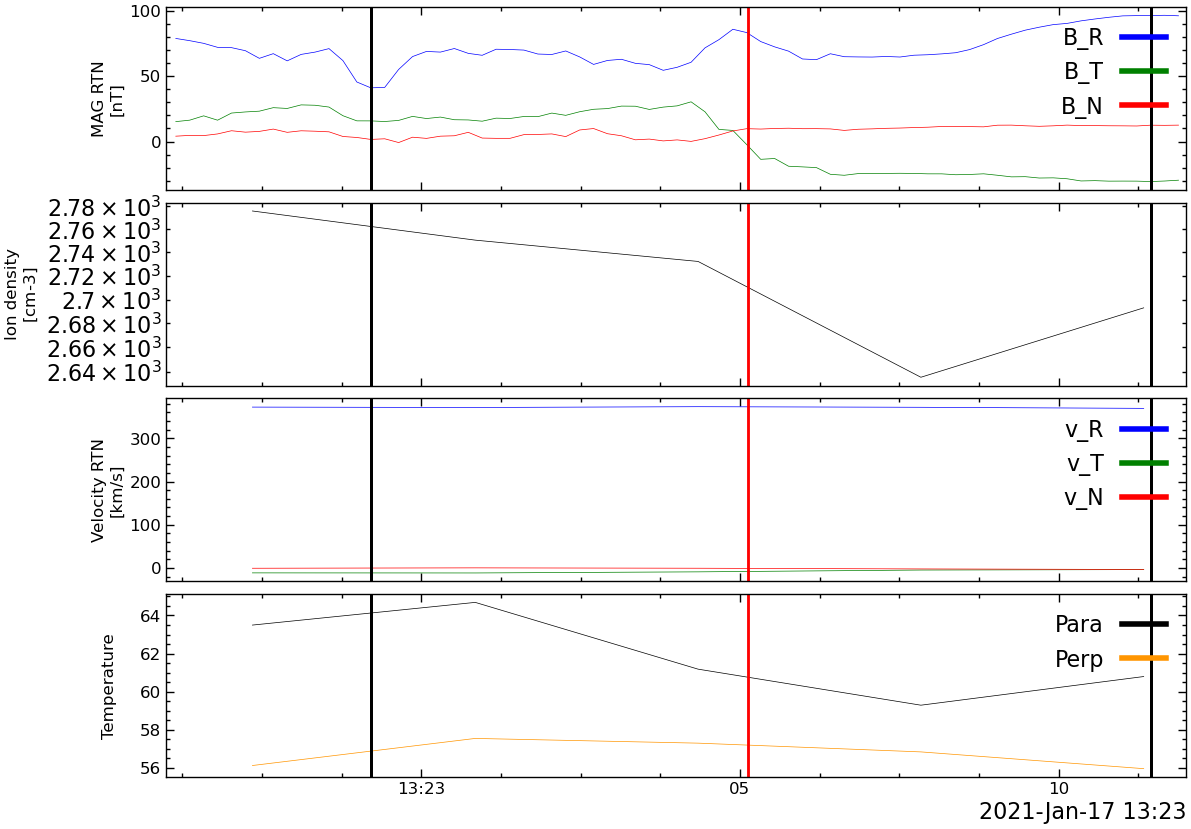

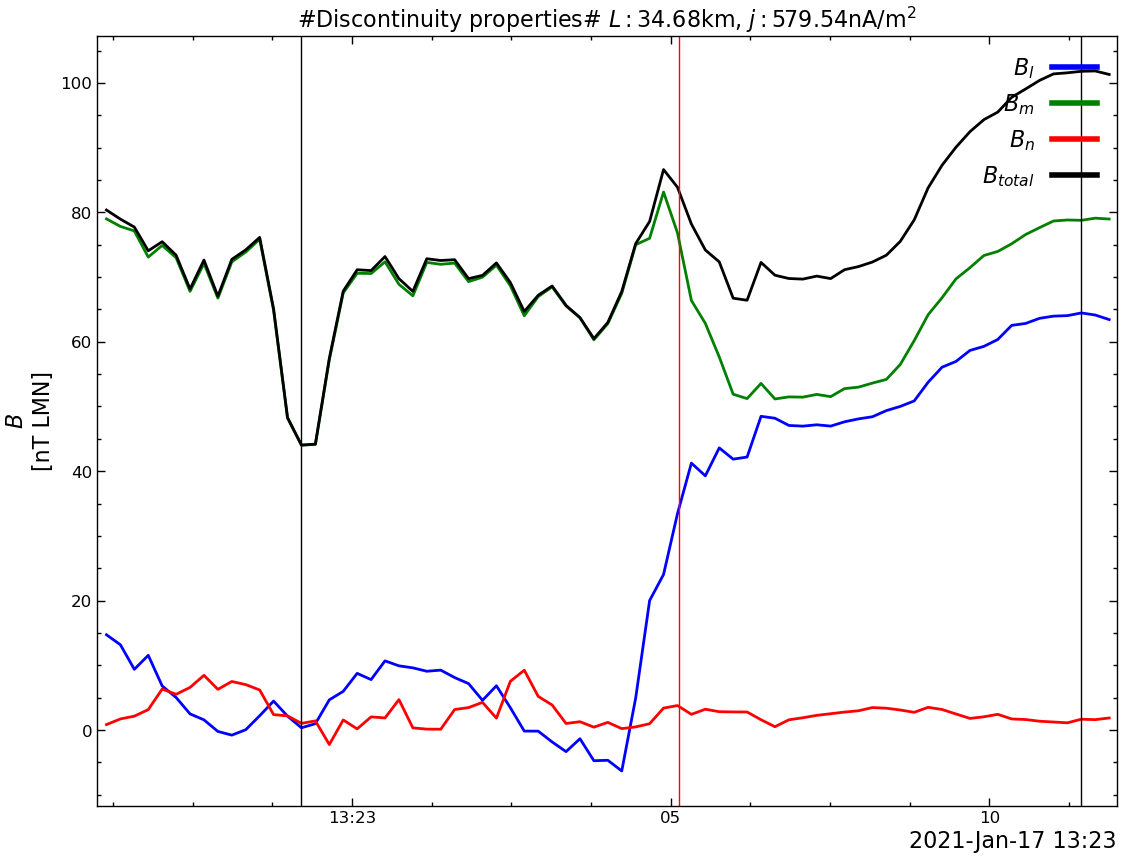

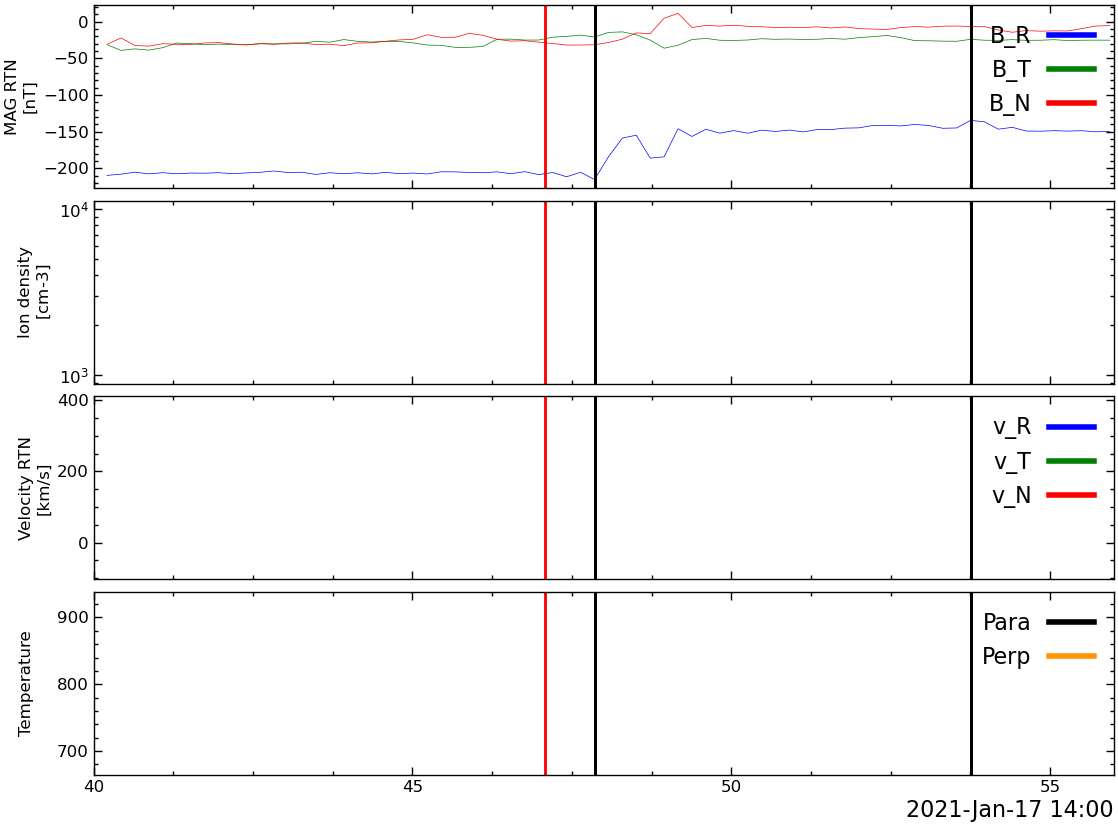

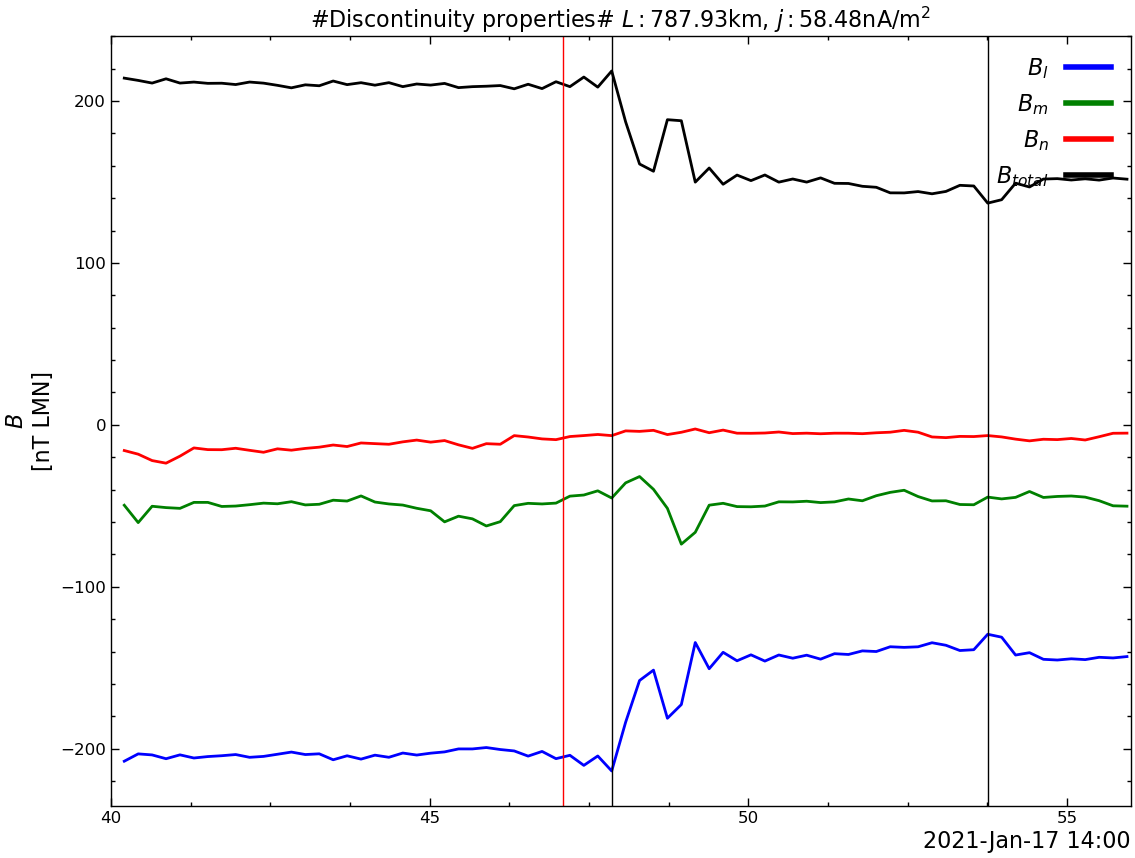

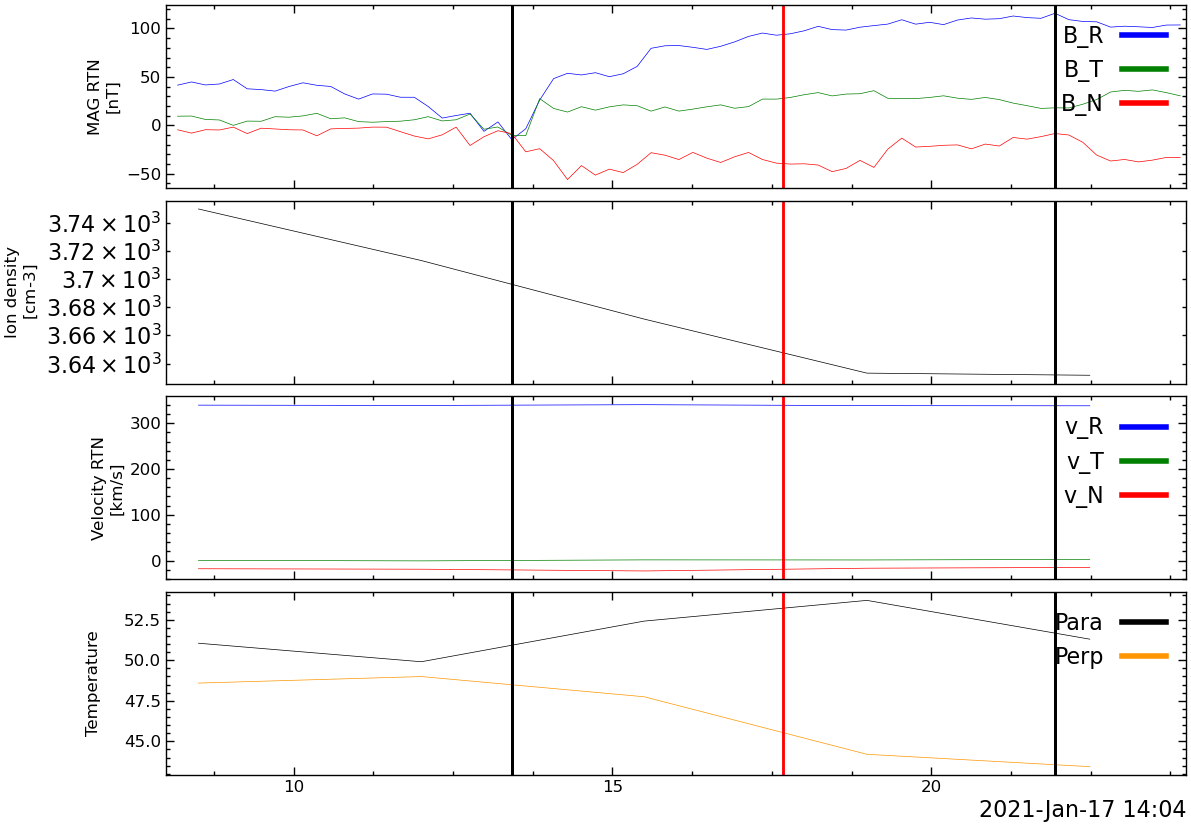

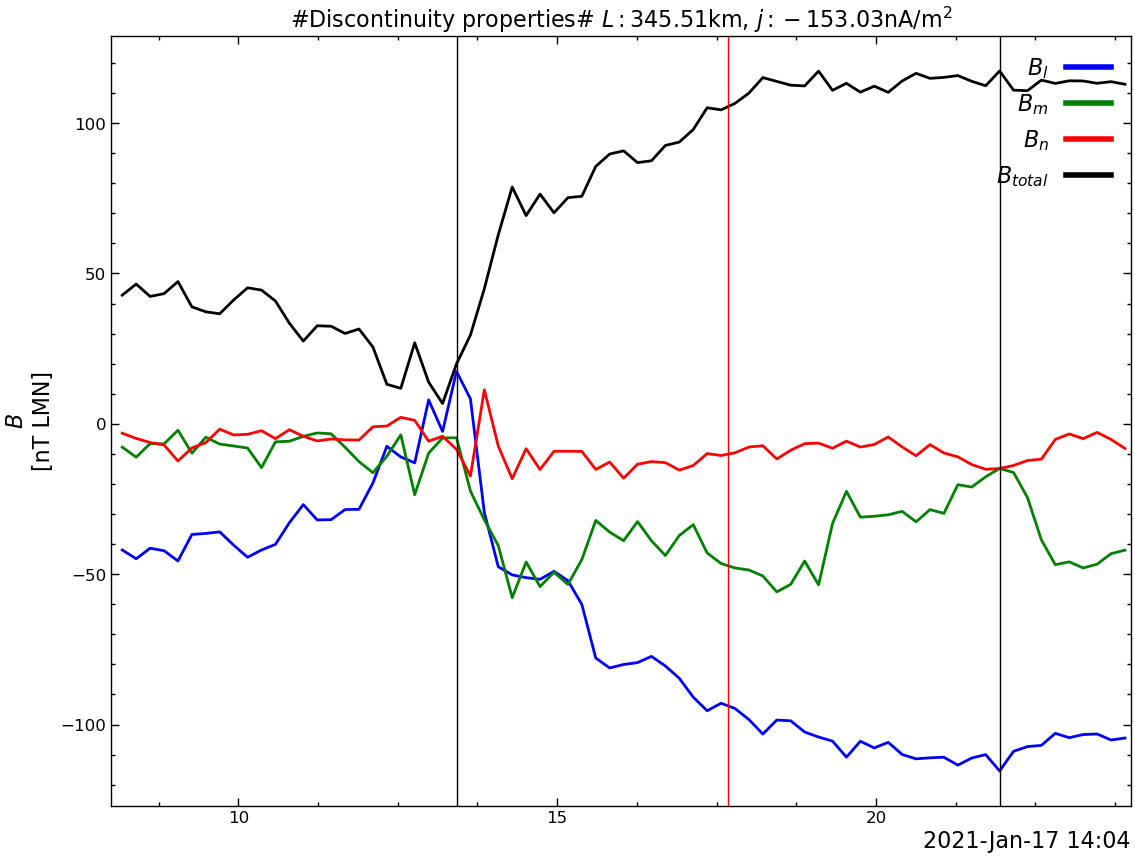

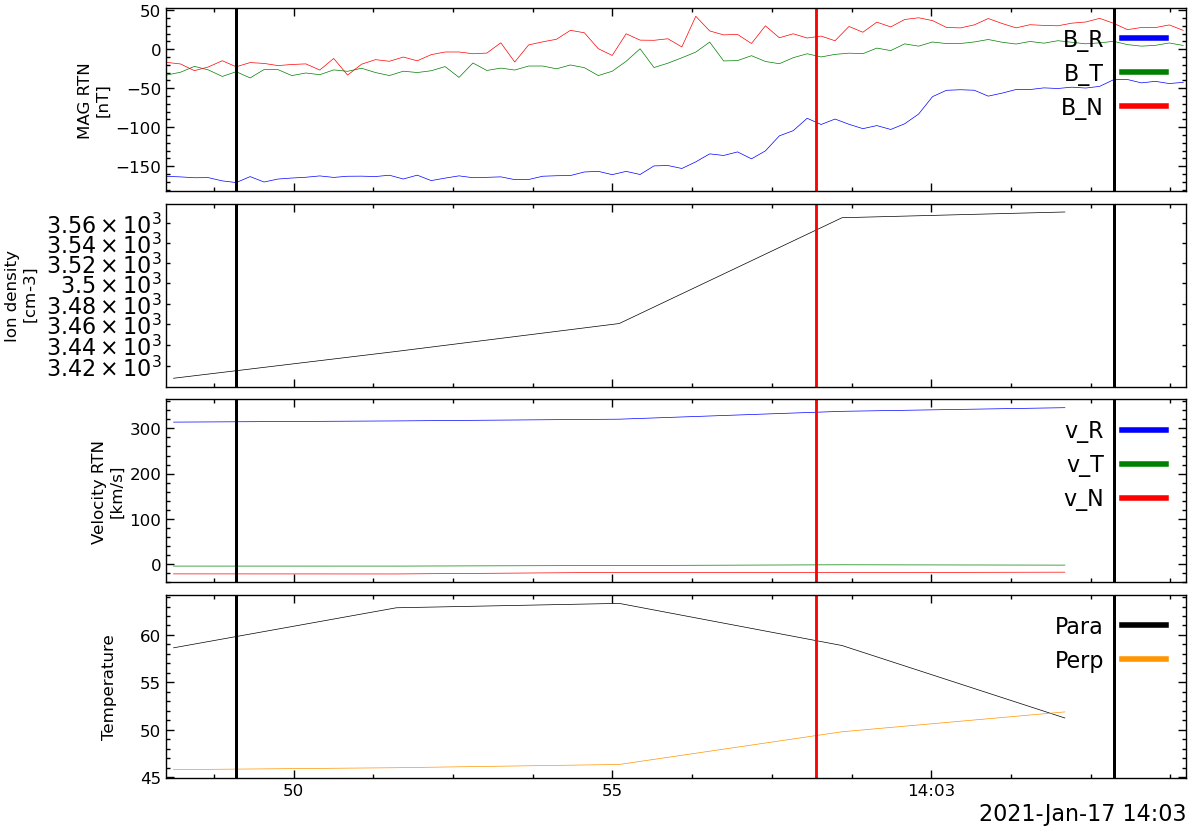

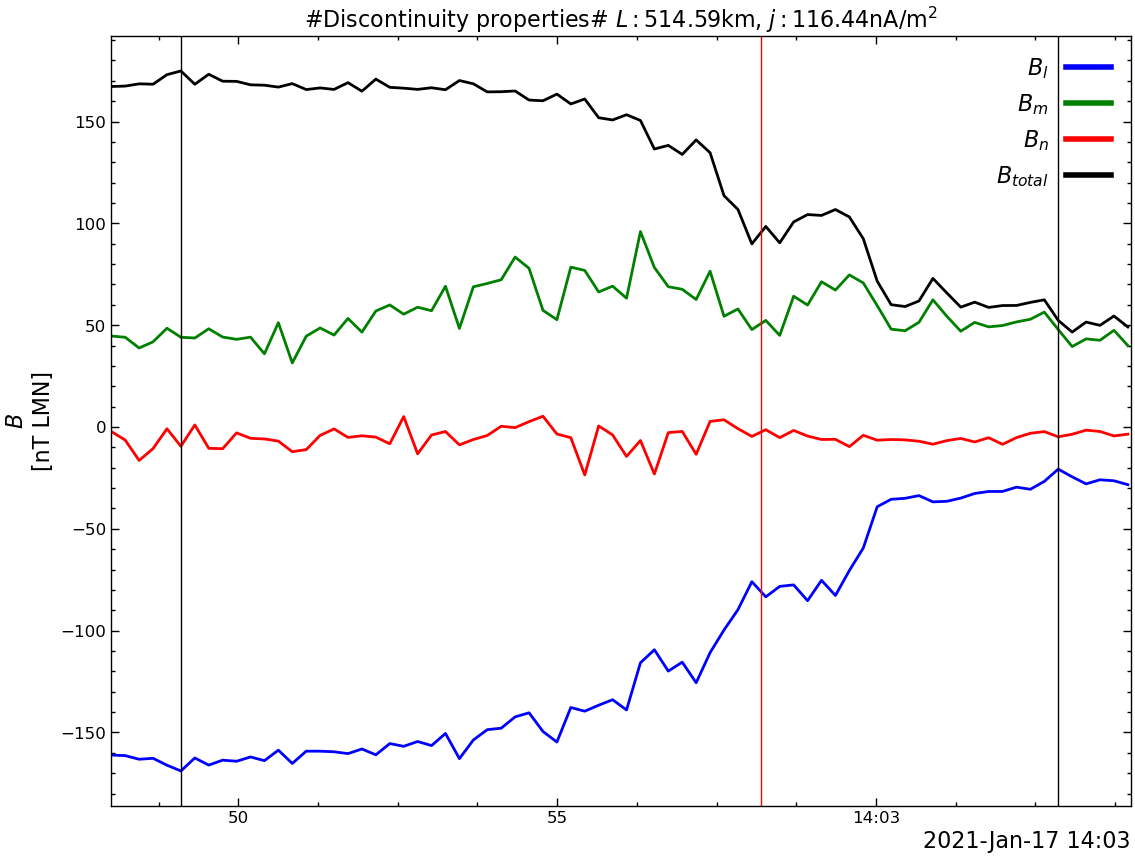

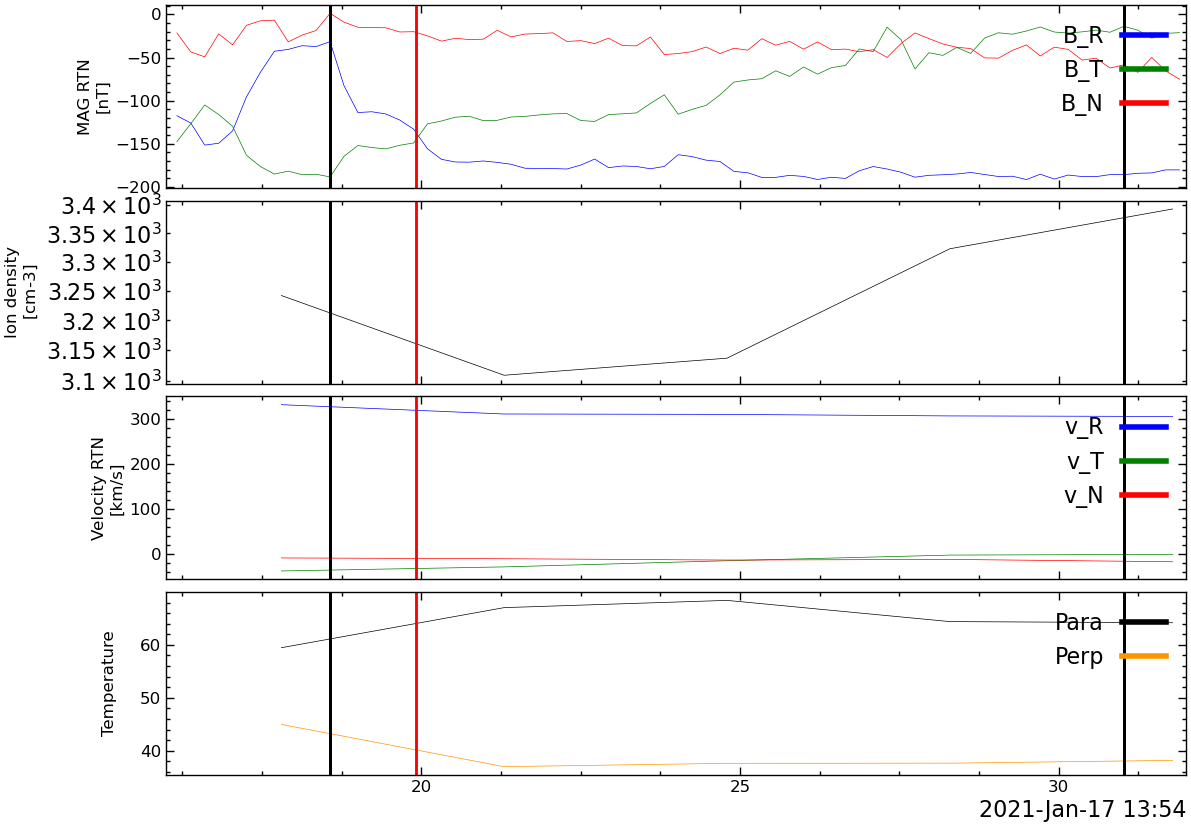

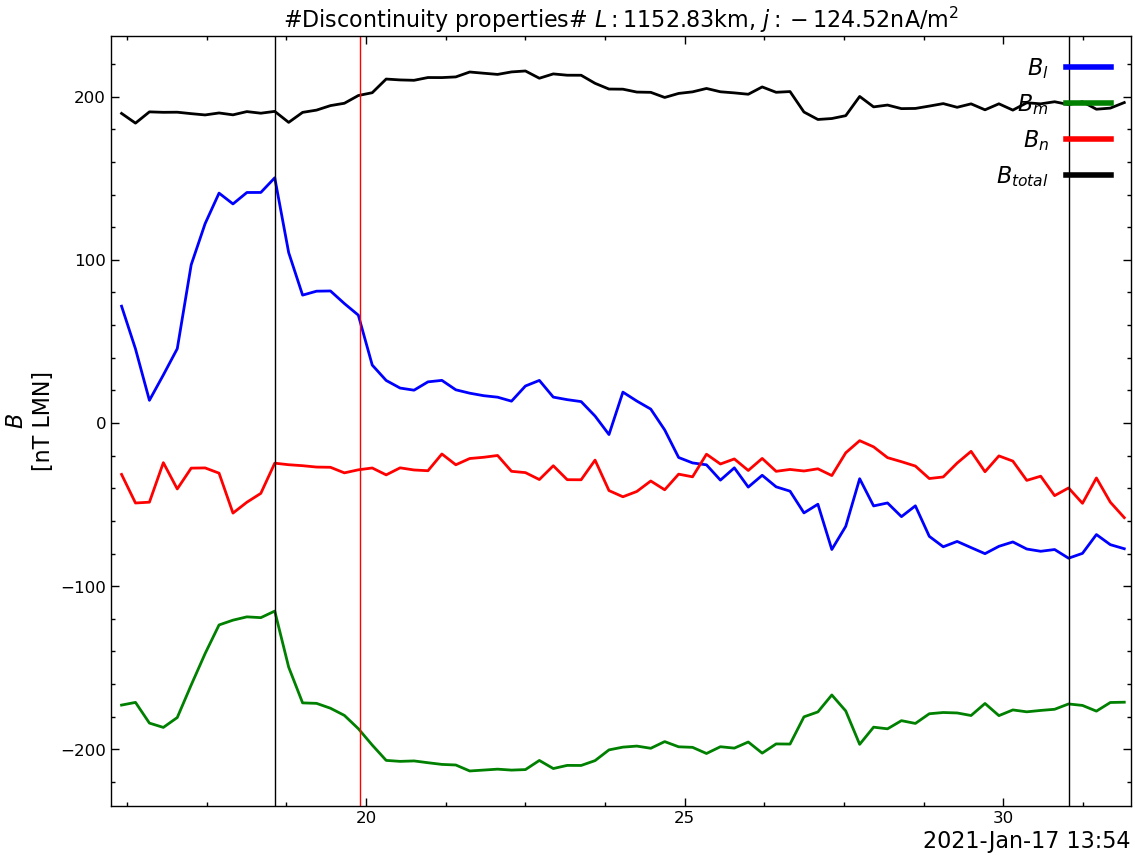

In [25]:
#| layout-ncol: 2
#| column: page
pytplot.tplot_options('ysize', 10)

for event in events.rows(named=True):
    plot_event(event, tnames2plot)
    plot_candidate_tplot(event)